In [1]:
import selenium
from time import sleep
from selenium import webdriver
from collections import Counter
from IPython.display import Image
from pymorphy2 import MorphAnalyzer
from nltk.tokenize import word_tokenize
from sklearn.metrics import accuracy_score

In [2]:
morph = MorphAnalyzer()

Функция, которая получает 'pos' или 'neg', собирает список из 200 отзывов с соответствующей оценкой и возвращает его:

In [3]:
def get_reviews(rating):
    DRIVER.get(URL)
    sleep(SLEEP_TIME)
    DRIVER.find_element_by_class_name(rating).find_element_by_tag_name('a').click()
    DRIVER.find_element_by_class_name('navigator_per_page').find_element_by_xpath("//option[@value='200']").click()
    sleep(SLEEP_TIME)
    reviews = [el.text
               for el in DRIVER.find_elements_by_class_name('_reachbanner_')]
    return reviews

In [4]:
URL = 'https://www.kinopoisk.ru/film/401177/reviews/'
DRIVER = webdriver.Chrome('C:\\Users\\HP\\Downloads\\chromedriver_win32\\chromedriver.exe')
SLEEP_TIME = 3

Сформируем списки текстов и закроем драйвер:

In [6]:
pos_reviews = get_reviews('pos')

In [7]:
neg_reviews = get_reviews('neg')

In [8]:
DRIVER.close()

Функция, которая получает текст одного отзыва, разбивает его на токены, каждый токен приводит к нижнему регистру и начальной форме и возвращает список слов:

In [9]:
def transform_text(review):
    ana_words = []
    words = [w.lower() for w in word_tokenize(review) if w.isalpha()]
    for word in words:
        ana_words.append(morph.parse(word)[0].normal_form)
    return ana_words

Функция, которая берет список из текстов, проходит по нему предыдущей функцией, считает все вхождения всех слов и формирует упорядоченный по частотности словарь:

In [10]:
def collect_freqlist(reviews, max_len=100):
    freqlist = Counter()
    for review in reviews:
        for word in transform_text(review):
            freqlist[word] += 1
    return dict(freqlist.most_common(max_len))

Функция, которая получает 2 словаря и удаляет из первого все слова, которые есть во втором, возвращает обновленный первый словарь:

In [11]:
def clean_freq(freq1, freq2):
    freq = {}
    for key in freq1.keys():
        if key not in freq2:
            freq[key] = freq1[key]
    return freq

Создаем список freqs, куда будем складывать сырые частотные словари (это лишнее, но я не успела найти способ избежать такого решения, не меняя половину кода), полученные в результате обработки двух списков с отзывами (точнее, их части - последние 30 отзывов были оставлены для теста). После этого создаем словарь, ключами которого будут 'pos' и 'neg', а значениями словари, полученные в результате работы функции clean_freq. Получаем словарь, в котором содержатся слова, встречающиеся только в негативных или только в положительных отзывах.

In [12]:
freqs = []
for rate in [pos_reviews, neg_reviews]:
    freqs.append(collect_freqlist(rate[:170]))
freq_lists = {'pos': clean_freq(freqs[0], freqs[1]),
              'neg': clean_freq(freqs[1], freqs[0])}

Функция, определяющая оценку фильма. На вход подается частотный словарь и текст отзыва. Внутри текст так же разбивается на токены, которые приводятся к нижнему регистру и начальной форме. Каждое слово сопоставляется с частотным словарем возможных оценок, подсчитывается количество совпадений. На выход дается массив из упорядоченных по частотности кортежей, в которых первый элемент - возможная оценка, а второй - количество слов, относящихся к этой оценке

In [13]:
def rate_detect(freq_lists, text):
    counts = Counter()
    for rate, freq_list in freq_lists.items():
        freq_list = Counter(freq_list)
        for word in transform_text(text):
            counts[rate] += int(freq_list[word] > 0)
    return counts.most_common()

Функция, на вход которой дается оценка и число (предполагается, что не больше 30, чтобы не заходить на тексты, на основе которых создавались списки слов), а на выходе выдается определенное количество текстов с такой оценкой:

In [14]:
def get_test_text(rate, number):
    if rate == 'pos':
        return pos_reviews[-number:]
    elif rate == 'neg':
        return neg_reviews[-number:]

Функция, проверяющая точность определения языка. Получает частотный словарь и число текстов, проходит по текстам, полученным с помощью предыдущей функции, предполагает оценку, создает списки из предполагаемых и фактических оценок фильма в отзывах и считает точность угадывания:

In [15]:
def test_rate_detect(freq_lists, test_size):
    results = []
    gold = []
    for rate in ['pos', 'neg']:
        for text in get_test_text(rate, test_size):
            predicted_rate = rate_detect(freq_lists, text)[0][0]
            results.append(predicted_rate)
            gold.append(rate)
    print("Accuracy: %.4f" % accuracy_score(results, gold))

Посчитаем точность для 30 текстов:

In [16]:
test_rate_detect(freq_lists, 30)

Accuracy: 0.6833


жаба расстроенная небольшой точностью:

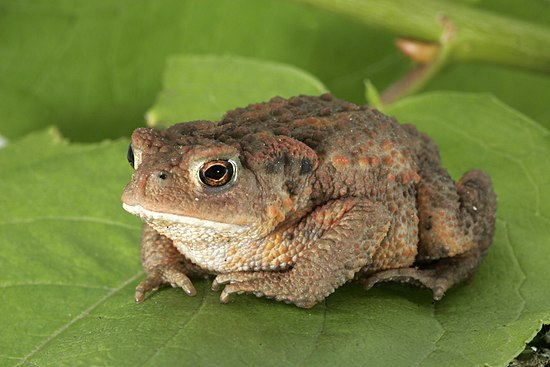

In [17]:
Image("https://upload.wikimedia.org/wikipedia/commons/thumb/0/01/Bufo_bufo_03-clean.jpg/550px-Bufo_bufo_03-clean.jpg")